# Circuit of Quantum Fourier Transform using TheQ

This notebook will teach you how to construct your own circuits for the Quantum Fourier Transform using TheQ.

# Importing Packages

In [ ]:
# Server addresses should be stable, but may occasionally be offline
import requests
import json
import math
from google.colab import files
req_str = 'http://8b851bd5c0ec.ngrok.io/qsim/perform_operation'
req_str_qasm = 'http://8b851bd5c0ec.ngrok.io/qsim/qasm'

import numpy as np
import time

# Required functions

These are some required functions to run any circuit in TheQ.

In [ ]:
# Define Create ciruit (these are the four core definitions for any circuit)
# all circuits must be bookmarked by the create_circuit and destroy_circuit command

# Initial_state is a binary integer to initalise all qubit, 
# most often initial_state=0.
def create_circuit(qubits,initial_state):
    data = {
        'operation': 'create_circuit',
        'num_qubits': qubits
    }
    result = requests.post(req_str, json=data)
    json_obj = json.loads(result.content)
    reg_id = json_obj['result']

    data = {
        'operation': 'set_state',
        'register': reg_id,
        'state': initial_state,
        'complex_value': {'re': 1, 'im': 0}
    }
    result = requests.post(req_str, json=data)
    return reg_id

# Gates.  gate_name and params are specified from the list above
def gate(register_id, gate_name, params):
    data = {
        'operation': 'gate',
        'register': register_id,
        'gate': gate_name
    }
    for k in params.keys():
        data[k] = params[k]
    result = requests.post(req_str, json=data)
    json_obj=json.loads(result.content)
    return json_obj['result']

# params contain an array of qubit numbers to measure, 'lq2m': [0,1,3] would measure qubits 0, 1 and 3 and return the 
# corresponding 3-bit integer value from 0 to 7.
def measure_qubit(register_id, params):
    data = {
        'operation': 'measure', 
        'register': register_id,
    }
    for k in params.keys():
        data[k] = params[k]
    result = requests.post(req_str, json=data)

    json_obj = json.loads(result.content)
    return json_obj['result']

# Always call destroy_circuit to terminate simulation (turn off your QC)
def destroy_circuit(register_id):
  data = {
        'operation': 'destroy_circuit', 
        'register': register_id
  }
  result = requests.post(req_str, json=data)

# Print allows you to output the current computational state of the machine.
def print_vector(register_id):
  data = {
        'operation': 'state_vector', 
        'register': register_id
  }
  result = requests.post(req_str, json=data)
  json_obj = json.loads(result.content)
  return json_obj['result']



# The circuits

Now, we move on to main part of the notebook. In this section, we shall explain the construction of circuits for the Quantum Fourier Transform (QFT) acting on for 4 qubits. The QFT can be implemented using two types of gates, Hadamard and controlled-$R_k$, where controlled-$R_k$ is given as

\begin{equation}
  R_k =
  \begin{bmatrix}
    1 & 0 & 0 & 0\\
    0 & 1 & 0 & 0\\
    0 & 0 & 1 & 0\\
    0 & 0 & 0 & e ^ {\frac{2 \pi i}{2 ^ k}}
  \end{bmatrix}
\end{equation}

Each of these controlled-$R_k$ gates can be implemented using the controlled phase gate available in TheQ, whose structure is given as 

\begin{equation}
  CPHASE (\phi) =
  \begin{bmatrix}
    1 & 0 & 0 & 0\\
    0 & 1 & 0 & 0\\
    0 & 0 & 1 & 0\\
    0 & 0 & 0 & e ^ {i \phi}
  \end{bmatrix}
\end{equation}


# QFT on 4 qubits

Let $x = x_1 x_2 x_3 x_4$ be a bit string of length $4$. The QFT on $4$ qubits is the operator defined as 
\begin{equation}
  QFT|x_1x_2x_3x_4\rangle = \frac{1}{4} \sum \limits_{j = 0}^{15} e ^ {\frac{2 \pi i (j \cdot x)}{16}} |j\rangle
\end{equation}

The circuit for Quantum Fourier Transform on $4$ qubits is given as

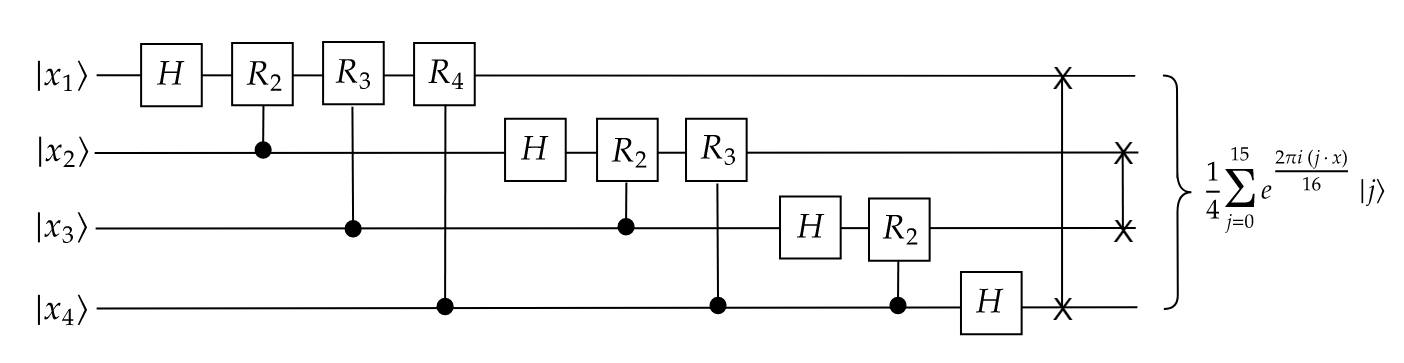

Now, we move on to constructing this circuit using TheQ

Since the circuit contains four qubits, we create a circuit with four qubits.

In [ ]:
# Prepare the circuit
reg_id = create_circuit(4,0)

Now, we shall start applying the gates. The first section of the circuit is to apply a $H$ gate on the most significant bit and a set of $CZ ^ {n}$ gates targeted on the same qubit. 

In [ ]:
# Apply Hadamard gate on the most significant bit.
gate(reg_id, 'hadamard', {'q': 3})

# Apply the sequence of CPHASE(phi) gates
gate(reg_id, 'cphase', {'q_control': 2, 'q_target': 3, 'theta': np.pi/2})
gate(reg_id, 'cphase', {'q_control': 1, 'q_target': 3, 'theta': np.pi/4})
gate(reg_id, 'cphase', {'q_control': 0, 'q_target': 3, 'theta': np.pi/8})

True

We'll move on to the next most significant qubit.

In [ ]:
# Apply Hadamard gate on the next most significant bit.
gate(reg_id, 'hadamard', {'q': 2})

# Apply the sequence of CPHASE(phi) gates
gate(reg_id, 'cphase', {'q_control': 1, 'q_target': 2, 'theta': np.pi/2})
gate(reg_id, 'cphase', {'q_control': 0, 'q_target': 2, 'theta': np.pi/4})

True

Now let's complete the circuit.

In [ ]:
# Apply Hadamard gate on the next most significant bit. 
gate(reg_id, 'hadamard', {'q': 1})

# Apply the last CPHASE(phi) gate
gate(reg_id, 'cphase', {'q_control': 0, 'q_target': 1, 'theta': np.pi/2})

# Apply Hadamard gate on the least significant bit. 
gate(reg_id, 'hadamard', {'q': 0})

True

Lets apply the final two swap gates

In [ ]:
# Swap gate applied by 3 successive CNOT gates between q0 and q3
gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 3})
gate(reg_id, 'cnot', {'q_control': 3, 'q_target': 0})
gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 3})

# Swap gate applied by 3 successive CNOT gates between q1 and q2
gate(reg_id, 'cnot', {'q_control': 1, 'q_target': 2})
gate(reg_id, 'cnot', {'q_control': 2, 'q_target': 1})
gate(reg_id, 'cnot', {'q_control': 1, 'q_target': 2})

True

We have completed the construction of the circuit. It is always a good habit to destroy the circuit after using.

In [ ]:
destroy_circuit(reg_id)

## Validation

For validating our circuit, we apply this circuit on all the possible basis vectors, and compare the result with the Fourier transform matrix. For that, we first prepare the Fourier Transform matrix $F$, whose $(j,k)^{th}$ element is $\frac{1}{4} e ^ {\frac{2 \pi i j \cdot k}{16}}$

In [ ]:
DFT = np.zeros((16,16)) + (1j * np.zeros((16,16)))
for j in range(16):
  for k in range(16):
    DFT[j][k] = (1/4) * np.cos((2 * np.pi * j * k)/16) + (1j * (1/4) * np.sin((2 * np.pi * j * k)/16))

Now, lets apply our quantum circuit on the state $|8\rangle$. If our circuit was correct, then the output of the circuit should be the $9^{th}$ column of the $DFT$ matrix defined in the previous cell. So, we shall compute the norm of difference between the $2$ vectors, that is
\begin{equation}
  \Big| \Big| QFT|8\rangle - DFT[:,8]\Big| \Big|_2
\end{equation}
If this value is close to 0, then we start to have more confidence in our circuit.

In [ ]:
# Initialize circuit 
reg_id = create_circuit(4,0)

# To prepare "8", we flip the most signifact qubit 
gate(reg_id, 'X', {'q': 3})

# Apply QFT
for j in range(3, -1, -1):
  gate(reg_id, 'hadamard', {'q': j})
  for k in range(j-1, -1, -1):
    gate(reg_id, 'cphase', {'q_control': k, 'q_target': j, 'theta': np.pi/(2 ** (j-k))})

for j in range(4):
  if j < 3 - j:
    gate(reg_id, 'cnot', {'q_control': j, 'q_target': 3-j})
    gate(reg_id, 'cnot', {'q_control': 3-j, 'q_target': j})
    gate(reg_id, 'cnot', {'q_control': j, 'q_target': 3-j})

Next step is to extract the state associated with the output of this circuit.

In [ ]:
statevector = np.zeros(16) + (1j * np.zeros(16))
for i in range(16):
  statevector[i] = print_vector(reg_id)[i]['complex_value']['re'] + (1j * print_vector(reg_id)[i]['complex_value']['im'])

Now lets compute the required norm

In [ ]:
np.linalg.norm(statevector - DFT[:,8])

2.0849072569817254e-15

As expected, we see that the value is 0.

Don't forget to destroy the circuit

In [ ]:
destroy_circuit(reg_id)

Now, we shall do a similar check on all basis states $|0\rangle, |1\rangle, \dots, |15\rangle$

In [ ]:
# This function converts a decimal number to its binary expansion
def Binary(x, BitNo):
  format(x, 'b').zfill(BitNo)
  Binlist = [int(y) for y in list(format(x, 'b').zfill(BitNo))]
  return Binlist

for i in range(16):

  # Compute the binary expansion of i
  bin_list = Binary(i, 4)

  # Reverse the output since Tin our circuit, 3 is the most signifcant qubit
  bin_list.reverse()

  # Initialize circuit 
  reg_id = create_circuit(4,0)

  # Prepare the state associated with i
  for j in range(4):
    if bin_list[j] == 1:
        gate(reg_id, 'X', {'q': j})

  # Apply QFT
  for j in range(3, -1, -1):
    gate(reg_id, 'hadamard', {'q': j})
    for k in range(j-1, -1, -1):
      gate(reg_id, 'cphase', {'q_control': k, 'q_target': j, 'theta': np.pi/(2 ** (j-k))})

  for j in range(4):
    if j < 3 - j:
      gate(reg_id, 'cnot', {'q_control': j, 'q_target': 3-j})
      gate(reg_id, 'cnot', {'q_control': 3-j, 'q_target': j})
      gate(reg_id, 'cnot', {'q_control': j, 'q_target': 3-j})

  # Extract the statevector
  statevector = np.zeros(16) + (1j * np.zeros(16))
  for j in range(16):
    statevector[j] = print_vector(reg_id)[j]['complex_value']['re'] + (1j * print_vector(reg_id)[j]['complex_value']['im'])

  # Display the norm of difference
  print("Norm of difference for the state associated with {} is {}".format(i, np.linalg.norm(statevector - DFT[:,i])))

  # Destroy the circuit
  destroy_circuit(reg_id)
  
  # Give TheQ a break
  time.sleep(10)

Norm of difference for the state associated with 0 is 3.3306690738754696e-16
Norm of difference for the state associated with 1 is 4.297039113746534e-16
Norm of difference for the state associated with 2 is 5.802634774236656e-16
Norm of difference for the state associated with 3 is 1.1152891720330888e-15
Norm of difference for the state associated with 4 is 1.062164269071369e-15
Norm of difference for the state associated with 5 is 1.3096669926994528e-15
Norm of difference for the state associated with 6 is 2.3197745446672062e-15
Norm of difference for the state associated with 7 is 2.6483700705796413e-15
Norm of difference for the state associated with 8 is 2.0849072569817254e-15
Norm of difference for the state associated with 9 is 2.159997305704014e-15
Norm of difference for the state associated with 10 is 2.6549365793190347e-15
Norm of difference for the state associated with 11 is 3.539207232753167e-15
Norm of difference for the state associated with 12 is 4.6807436717309964e-15
N

Seeing that all the possible norm differnces are $0$, we can safely conclude that our circuit is indeed the Quantum Fourier Transform acting on $4$ qubits.

The code snippet given below prepares and executes a Quantum Fourier Transform on any number of qubits and validates the result after that.

In [ ]:
number_of_qubits = 3

# Prepare the Fourier Transform matrix for validation later
DFT = np.zeros((2 ** number_of_qubits,2 ** number_of_qubits)) + (1j * np.zeros((2 ** number_of_qubits,2 ** number_of_qubits)))
for k1 in range(2 ** number_of_qubits):
  for k2 in range(2 ** number_of_qubits):
    DFT[k1][k2] = (1/np.sqrt(2 ** number_of_qubits)) * np.cos((2 * np.pi * k1 * k2)/2 ** number_of_qubits) + (1j * (1/np.sqrt(2 ** number_of_qubits)) * np.sin((2 * np.pi * k1 * k2)/2 ** number_of_qubits))

for i in range(2 ** number_of_qubits):

  # Compute the binary expansion of i
  bin_list = Binary(i, number_of_qubits)

  # Reverse the output since the last qubit is the most signifact in the circuit
  bin_list.reverse()

  # Initialize circuit 
  reg_id = create_circuit(number_of_qubits,0)

  # Prepare the state associated with i
  for j in range(number_of_qubits):
    if bin_list[j] == 1:
        gate(reg_id, 'X', {'q': j})

  # Apply QFT
  for j in range(number_of_qubits - 1, -1, -1):
    gate(reg_id, 'hadamard', {'q': j})
    for k in range(j-1, -1, -1):
      gate(reg_id, 'cphase', {'q_control': k, 'q_target': j, 'theta': np.pi/(2 ** (j-k))})

  for j in range(number_of_qubits):
    if j < number_of_qubits - j - 1:
      gate(reg_id, 'cnot', {'q_control': j, 'q_target': number_of_qubits-1-j})
      gate(reg_id, 'cnot', {'q_control': number_of_qubits-1-j, 'q_target': j})
      gate(reg_id, 'cnot', {'q_control': j, 'q_target': number_of_qubits-1-j})

  # Extract the statevector
  statevector = np.zeros(2 ** number_of_qubits) + (1j * np.zeros(2 ** number_of_qubits))
  for j in range(2 ** number_of_qubits):
    statevector[j] = print_vector(reg_id)[j]['complex_value']['re'] + (1j * print_vector(reg_id)[j]['complex_value']['im'])

  # Display the norm of difference
  print("Norm of difference for the state associated with {} is {}".format(i, np.linalg.norm(statevector - DFT[:,i])))

  # Destroy the circuit
  destroy_circuit(reg_id)

  # Give TheQ a break
  time.sleep(10)


Norm of difference for the state associated with 0 is 1.5700924586837752e-16
Norm of difference for the state associated with 1 is 2.2181376455079022e-16
Norm of difference for the state associated with 2 is 2.7774717943000184e-16
Norm of difference for the state associated with 3 is 5.676479939535573e-16
Norm of difference for the state associated with 4 is 5.358263387087105e-16
Norm of difference for the state associated with 5 is 1.276148583654803e-15
Norm of difference for the state associated with 6 is 1.0944265166593505e-15
Norm of difference for the state associated with 7 is 1.620681331014975e-15
